# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

## Problem Set 5: FFT-based convolution

a) nicht gemacht
b)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#Reads a square image in 8-bit/color PPM format from the given file. Note: No checks on valid format are done.
def readImage(filename):
    f = open(filename,"rb")
    
    f.readline()
    s = f.readline()
    f.readline()
    (pixel, pixel) = [t(s) for t,s in zip((int,int),s.split())]
    
    data = np.fromfile(f,dtype=np.uint8,count = pixel*pixel*3)
    img = data.reshape((pixel,pixel,3)).astype(np.double)
    
    f.close()
    
    return img, pixel
    

#Writes a square image in 8-bit/color PPM format.
def writeImage(filename, image):
    f = open(filename,"wb")
    
    pixel = image.shape[0]
    header= "P6\n%d %d\n%d\n"%(pixel, pixel, 255)
    f.write(bytearray(header, 'ascii'))
    
    image = image.astype(np.uint8)
    
    image.tofile(f)
    
    f.close()
    
    
# function to compute the power spectrum
def _compute_spectrum_2D(fourier_2D_data):

    npix = fourier_2D_data.shape[0]

    fourier_amplitudes = np.abs(fourier_2D_data)**2
    
    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "sum",
                                     bins = kbins)
    Abins = Abins * np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins    

[20920800. 20023592. 20906226.]


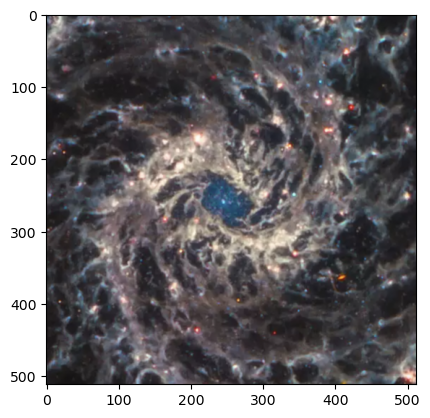

In [28]:
img, pixel = readImage("ngc628-original.ppm")
print(img.sum(axis=(0,1)))
img = img/img.max()
imgmax = img.max()
plt.imsave("normal.png",img/img.max())
plt.imshow(img/img.max())
plt.show()

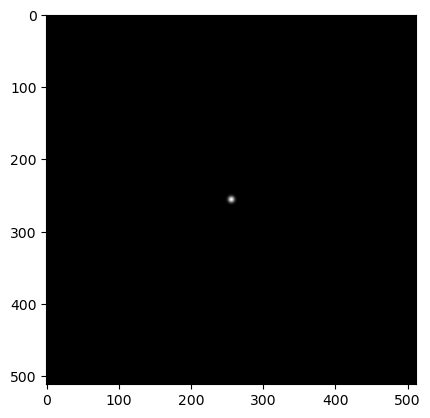

In [29]:
def Kernel(x,y, h):
    r = np.sqrt(x**2+y**2)
    if 0 <= r/h  < 0.5:
        return 1 - 6*(r/h)**2 + 6*(r/h)**3
    elif 0.5 <=  r/h < 1:
        return 2*(1-r/h)**3
    else: 
        return 0
    
#Now we set up our desired smoothing kernel. We'll use complex number for it even though it is real. 
kernel_real = np.zeros((pixel,pixel),dtype=np.complex128)

hsml = 10.

nx,ny,cs = img.shape

#now set the values of the kernel 
for i in np.arange(pixel):
    for j in np.arange(pixel):
        ix, iy = i-nx//2, j-ny//2
        kernel_real[i,j] = Kernel(ix, iy,hsml)

# Normalization
kernel_real = kernel_real/np.sum(kernel_real)

plt.imshow(kernel_real.real, cmap="gray")
plt.show()

[82042.35294117 78523.89019608 81985.2       ]


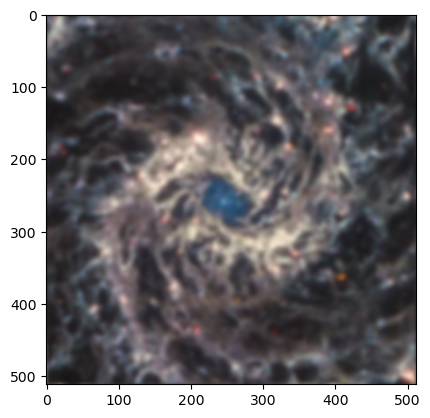

In [30]:
kernel_real = np.fft.ifftshift(kernel_real)                                                                                                                                                  

#Let's calculate the Fourier transform of the kernel
kernel_kspace = np.fft.fft2(kernel_real)

#further space allocations for image transforms
color_real = np.zeros((pixel,pixel),dtype=np.complex128)

# variables for the spectra 
# - store spectrum of the original image and the smoothed one
# - three spectra for each color
spectrum_original = np.zeros((3,pixel//2))#pixel, pixel))
spectrum_filter   = np.zeros((3,pixel//2))#pixel, pixel))

#we now convolve each color channel with the kernel using FFTs
for colindex in np.arange(3):
    #copy input color into complex array
    color_real[:,:].real = img[:,:,colindex]
    
    #forward transform
    color_kspace = np.fft.fft2(color_real)

    #store image spectrum for original image
    _, spectrum_original[colindex] = _compute_spectrum_2D(color_kspace) #np.abs(np.fft.fftshift(color_kspace))**2
    
    #multiply with kernel in Fourier space                                                                                                                                                         
    color_kspace = color_kspace * np.conj(kernel_kspace)
  
    #store image spectrum for smoothed image
    _, spectrum_filter[colindex] =  _compute_spectrum_2D(color_kspace)#np.abs(np.fft.fftshift(color_kspace))**2

    #backward transform
    color_real = np.fft.ifft2(color_kspace)
    
    #copy real value of complex result back into color array
    img[:,:,colindex] = color_real.real

print((img*imgmax).sum(axis=(0,1)))

img = img/img.max()


plt.imshow(img)
plt.imsave("smooethed.png",img)
plt.show()



writeImage("ngc628-smoothed.ppm", img)


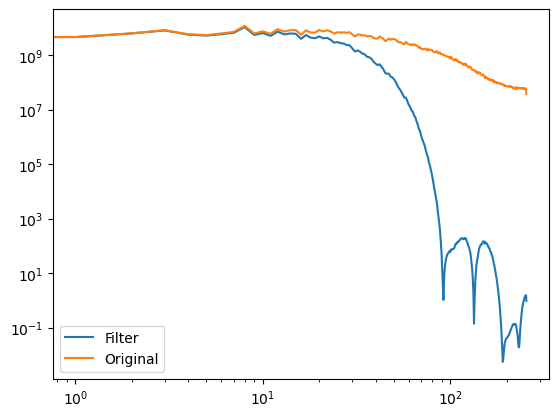

In [31]:
plt.plot(spectrum_filter.sum(axis=0), label="Filter")
plt.plot(spectrum_original.sum(axis=0), label="Original")
plt.legend()
plt.yscale("log")
plt.xscale("log")

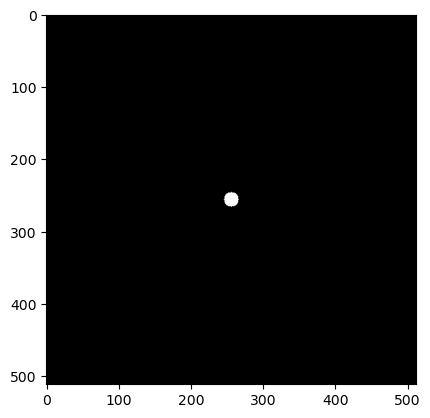

In [22]:
def Kernel(x,y, h):
    r = np.sqrt(x**2+y**2)
    if r/h <= 1:
        return 1
    else:
        return 0
    
#Now we set up our desired smoothing kernel. We'll use complex number for it even though it is real. 
kernel_real = np.zeros((pixel,pixel),dtype=np.complex128)

hsml = 10.

nx,ny,cs = img.shape

#now set the values of the kernel 
for i in np.arange(pixel):
    for j in np.arange(pixel):
        ix, iy = i-nx//2, j-ny//2
        kernel_real[i,j] = Kernel(ix, iy,hsml)

# Normalization
kernel_real = kernel_real/np.sum(kernel_real)

plt.imshow(kernel_real.real, cmap="gray")
plt.show()

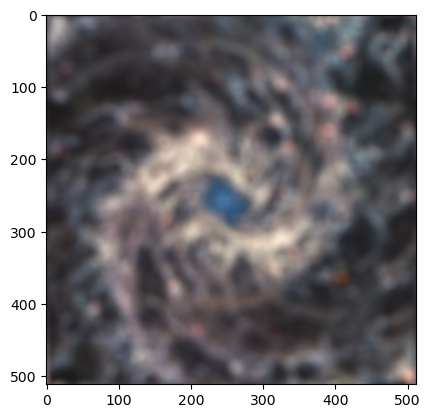

In [23]:
kernel_real = np.fft.ifftshift(kernel_real)                                                                                                                                                  

#Let's calculate the Fourier transform of the kernel
kernel_kspace = np.fft.fft2(kernel_real)

#further space allocations for image transforms
color_real = np.zeros((pixel,pixel),dtype=np.complex128)

# variables for the spectra 
# - store spectrum of the original image and the smoothed one
# - three spectra for each color
spectrum_original = np.zeros((3,pixel//2))#pixel, pixel))
spectrum_filter   = np.zeros((3,pixel//2))#pixel, pixel))

#we now convolve each color channel with the kernel using FFTs
for colindex in np.arange(3):
    #copy input color into complex array
    color_real[:,:].real = img[:,:,colindex]
    
    #forward transform
    color_kspace = np.fft.fft2(color_real)

    #store image spectrum for original image
    _, spectrum_original[colindex] = _compute_spectrum_2D(color_kspace) #np.abs(np.fft.fftshift(color_kspace))**2
    
    #multiply with kernel in Fourier space                                                                                                                                                         
    color_kspace = color_kspace * np.conj(kernel_kspace)
  
    #store image spectrum for smoothed image
    _, spectrum_filter[colindex] =  _compute_spectrum_2D(color_kspace)#np.abs(np.fft.fftshift(color_kspace))**2

    #backward transform
    color_real = np.fft.ifft2(color_kspace)
    
    #copy real value of complex result back into color array
    img[:,:,colindex] = color_real.real

img = img/img.max()

plt.imshow(img)
plt.imsave("tophat.png",img)
plt.show()

writeImage("ngc628-tophat.ppm", img)


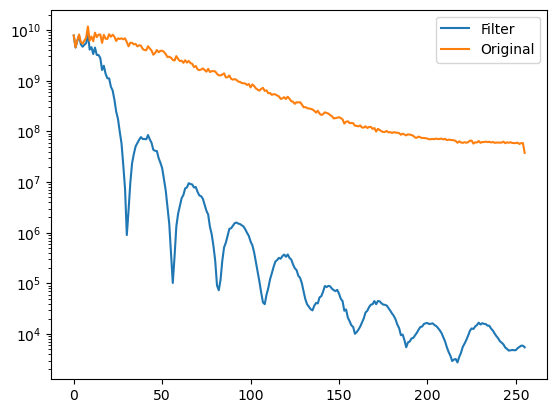

In [24]:
plt.plot(spectrum_filter.sum(axis=0), label="Filter")
plt.plot(spectrum_original.sum(axis=0), label="Original")
plt.legend()
plt.yscale("log")